In [419]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4-tf


In [420]:
data = pd.read_csv('train.csv')

In [421]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [422]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## Preprocessing

In [423]:
def encode_date(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column], dayfirst=True)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df = df.drop(column, axis=1)
    return df

def get_dummies(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [424]:
def preprocess_inputs(df):
    df= df.copy()
    
    #drop unnecessary columns
    df = df.drop(['Row ID', 'Country', 'Customer Name', 'Product Name'], axis=1)
    
    #drop customer specific features
    df = df.drop(['Customer ID', 'Order ID'], axis=1)
    
    # get dates
    df = encode_date(df, column='Order Date')
    df = encode_date(df, column='Ship Date')
    
    #get dummies 
    for column in ['Ship Mode', 'Segment', 'City' , 'State', 'Postal Code', 'Region', 'Product ID' ,'Category', 'Sub-Category']:
        df = get_dummies(df, column=column)
    
    # split df into X and Y
    y= df['Sales']
    X = df.drop('Sales', axis=1)
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.80, shuffle=True,random_state=1)
    
    # scale X , Note: we only fit the scaler to x_train
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test
    

In [425]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [426]:
#{column: len(X[column].unique()) for column in X.columns}

In [427]:
for i in X_train, X_test, y_train, y_test:
    print(i.shape)

(7840, 3102)
(1960, 3102)
(7840,)
(1960,)


In [428]:
# here we have our scaled training dataset, mean close to 0 and std deviation 1
X_train.describe()

,Order Date_day,Order Date_month,Order Date_year,Ship Date_day,Ship Date_month,Ship Date_year,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
count,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,...,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03
mean,1.132881e-17,-1.160070e-16,-8.082696e-14,-2.356392e-17,9.334936e-17,-2.723264e-14,-6.072240e-17,-3.942425e-17,-4.440892e-17,-6.887914e-17,...,-5.211251e-18,-8.700523e-17,4.803414e-17,-3.534588e-17,3.625218e-18,9.969350e-18,-8.360659e-17,7.431697e-17,-2.718914e-18,2.537653e-17
std,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,...,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00
min,-1.656664e+00,-2.074014e+00,-1.522877e+00,-1.693765e+00,-2.019916e+00,-1.534851e+00,-4.292901e-01,-2.487950e-01,-4.874106e-01,-1.209900e+00,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
25%,-8.568035e-01,-8.559249e-01,-6.336056e-01,-8.992338e-01,-8.215928e-01,-6.465272e-01,-4.292901e-01,-2.487950e-01,-4.874106e-01,-1.209900e+00,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
50%,-5.694339e-02,3.621639e-01,2.556654e-01,8.802391e-03,3.767305e-01,2.417962e-01,-4.292901e-01,-2.487950e-01,-4.874106e-01,8.265142e-01,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
75%,8.571824e-01,9.712083e-01,1.144936e+00,9.168386e-01,9.758922e-01,1.130120e+00,-4.292901e-01,-2.487950e-01,-4.874106e-01,8.265142e-01,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
max,1.771308e+00,1.275730e+00,1.144936e+00,1.711370e+00,1.275473e+00,2.018443e+00,2.329427e+00,4.019373e+00,2.051658e+00,8.265142e-01,...,6.072429e+00,6.737250e+00,3.097514e+00,5.186555e+00,9.029192e+00,2.481898e+00,3.188744e+00,3.312018e+00,7.284845e+00,5.431928e+00


In [429]:
X_train.head()

,Order Date_day,Order Date_month,Order Date_year,Ship Date_day,Ship Date_month,Ship Date_year,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,-0.971069,1.275730,1.144936,-0.785729,1.275473,1.130120,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,-0.137271,-0.184097
1,1.314245,-1.160447,-0.633606,-1.580261,-0.821593,-0.646527,-0.429290,-0.248795,-0.487411,0.826514,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,7.284845,-0.184097
2,0.400120,0.362164,0.255665,0.576325,0.376731,0.241796,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,2.481898,-0.313603,-0.301931,-0.137271,-0.184097
3,0.742917,-0.855925,0.255665,1.257352,-0.821593,0.241796,-0.429290,-0.248795,-0.487411,0.826514,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,3.188744,-0.301931,-0.137271,-0.184097
4,-1.656664,-1.464969,-0.633606,-1.353252,-1.420754,-0.646527,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,-0.137271,-0.184097


## Training Neural Network

In [430]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#create model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse',
              optimizer='adam',
              #metrics=['accuracy']
             )

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 256)               794368    
_________________________________________________________________
dense_96 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_97 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 33        
Total params: 837,633
Trainable params: 837,633
Non-trainable params: 0
_________________________________________________________________


In [431]:
# Train and evaluate 
batch_size = 16
epochs = 10

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
#print('Test accuracy:', score[1])

Train on 7840 samples, validate on 1960 samples
Epoch 1/10
7840/7840 [==============================] - 9s 1ms/sample - loss: 359302.6828 - val_loss: 235326.7537
Epoch 2/10
7840/7840 [==============================] - 6s 778us/sample - loss: 263811.4529 - val_loss: 211931.9548
Epoch 3/10
7840/7840 [==============================] - 6s 772us/sample - loss: 191277.3401 - val_loss: 198967.3129
Epoch 4/10
7840/7840 [==============================] - 6s 777us/sample - loss: 126661.5990 - val_loss: 190298.3646
Epoch 5/10
7840/7840 [==============================] - 6s 787us/sample - loss: 80044.3472 - val_loss: 231122.3012
Epoch 6/10
7840/7840 [==============================] - 6s 774us/sample - loss: 71540.9240 - val_loss: 207609.8345
Epoch 7/10
7840/7840 [==============================] - 6s 770us/sample - loss: 44472.9299 - val_loss: 179152.0784
Epoch 8/10
7840/7840 [==============================] - 6s 802us/sample - loss: 36772.0585 - val_loss: 182861.4047
Epoch 9/10
7840/7840 [========

In [432]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.45343


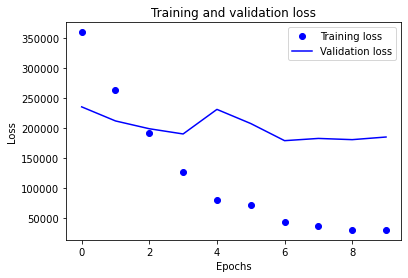

In [433]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [434]:
y_pred.shape

(1960, 1)

In [435]:
X_test.shape

(1960, 3102)

In [436]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])

In [437]:
sales_pred.reset_index()

,Sales,Sales_pred
0,526.450,63.680466
1,703.710,934.026306
2,360.712,157.761230
3,26.720,56.173859
4,1.938,5.738649
...,...,...
1955,78.759,119.270515
1956,20.860,22.940845
1957,7.310,12.859239
1958,105.686,362.745483


In [438]:
from tensorflow.keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        patience = 5, 
                                        restore_best_weights = True)

# Train and evaluate 
batch_size = 16
epochs = 10

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                   callbacks=[earlystopping,callbacks.ReduceLROnPlateau()])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
#print('Test accuracy:', score[1])

Train on 7840 samples, validate on 1960 samples
Epoch 1/10
7840/7840 [==============================] - 7s 842us/sample - loss: 24274.3122 - val_loss: 178600.8605
Epoch 2/10
7840/7840 [==============================] - 6s 771us/sample - loss: 31315.2013 - val_loss: 176744.8256
Epoch 3/10
7840/7840 [==============================] - 6s 778us/sample - loss: 29508.0833 - val_loss: 173021.8634
Epoch 4/10
7840/7840 [==============================] - 6s 793us/sample - loss: 19617.7566 - val_loss: 186477.4842
Epoch 5/10
7840/7840 [==============================] - 6s 765us/sample - loss: 18352.5008 - val_loss: 180547.2072
Epoch 6/10
7840/7840 [==============================] - 6s 776us/sample - loss: 32290.5573 - val_loss: 173526.6069
Epoch 7/10
7840/7840 [==============================] - 6s 771us/sample - loss: 23873.5173 - val_loss: 177316.9978
Epoch 8/10
7840/7840 [==============================] - 7s 950us/sample - loss: 25534.7373 - val_loss: 183757.7917
Test loss: 173021.8620695153


In [439]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.48942


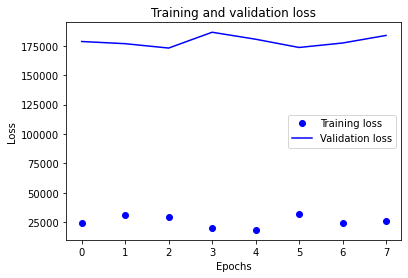

In [440]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [441]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])

In [442]:
sales_pred.reset_index()

,Sales,Sales_pred
0,526.450,201.752060
1,703.710,617.777466
2,360.712,234.459000
3,26.720,88.766251
4,1.938,6.550373
...,...,...
1955,78.759,90.882156
1956,20.860,19.506460
1957,7.310,6.386146
1958,105.686,381.080292
